In [1]:
from utils import *
%load_ext autoreload
%autoreload 2

In [57]:
X_train, y_train, X_test = read_train_test(sentence_per_row_mode=True)

Reading training data ...
Reading training data : Done
Reading testing data ...
Reading testing data : Done


In [58]:
X_train["text_joined"] = [" ".join(X_train.text[i]) for i in range(X_train.shape[0])]

In [59]:
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

stop_words = set(stopwords.words('french'))
stemmer = FrenchStemmer()

def process_text(text, stem=False):
    """ lowercase, removes stopwords, lemmatizes"""
    text = text.replace("’", " ").lower()
    tokens = text.split()
    if stem :
        tokens_no_stpwrd = [stemmer.stem(tok) for tok in tokens if tok not in stop_words]
    else :
        tokens_no_stpwrd = [tok for tok in tokens if tok not in stop_words]

    return " ".join(tokens_no_stpwrd)

X_train["text_processed"] = X_train.text_joined.apply(process_text, args=(False,))

In [4]:
# y_train.loc[X_train[X_train.filename == "Bordeaux_605561.txt"].index]

In [3]:
sex_prediction = X_train.text.apply(naive_sex_classifier, args=(0.85, 1))

In [11]:
print("Nombre de fois où on se trompe de sexe : {}".format((sex_prediction != y_train.sexe).sum()))
print("Dont : {} femmes".format((y_train[(sex_prediction != y_train.sexe)].sexe == "femme").sum()))

Nombre de fois où on se trompe de sexe : 90
Dont : 61 femmes


***

In [42]:
print("Total de texte : {}".format(X_train.shape[0]))
print("Le nombre de fois où le mot 'victime' apparait dans le texte : {}".format(X_train.text_joined.str.contains("victime").sum()))
print("Le nombre de fois où le mot 'APPELANTE' apparait dans le texte : {}".format(X_train.text_joined.str.contains("APPELANTE").sum()))

Total de texte : 770
Le nombre de fois où le mot 'victime' apparait dans le texte : 728
Le nombre de fois où le mot 'APPELANTE' apparait dans le texte : 267


# Extraction du contexte autour de la date d'accident

In [151]:
def date_parser(date_string):
    """ Transforme une date de YYYY-mm-DD 
        en DD mm (en lettre) YYYY """
    
    year_month_day = date_string.split('-')
    
    list_Months=['Janvier',"Février",
                 'Mars','Avril','Mai','Juin','Juillet',
                 "Août",'Septembre','Octobre','Novembre',
                 "Décembre"]
    list_months=['janvier',"février",
                 'mars','avril','mai','juin','juillet',
                 "août",'septembre','octobre','novembre',
                 "décembre"]
    
    day = str(int(year_month_day[2])) # sans le 0 qui précède les unités
    Month = list_Months[int(year_month_day[1])-1]
    month = list_months[int(year_month_day[1])-1]
    year = year_month_day[0]
    
    if day == "1":
        day +="er"
    return day + " " + Month + " " + year, day + " " + month + " " + year

In [152]:
def extract_X_sentences_before_after(text, date, X=2):
    
    try :
        capitalized_date, non_capitalized_date = date_parser(date)
    except :
        return "Date NC"
    
    L1 = [capitalized_date in sen for sen in text]
    L2 = [non_capitalized_date in sen for sen in text]
    
    if np.array(L1).any() :
        index = np.where(L1)[0][0]
        CAP=True
    elif np.array(L2).any() :
        index = np.where(L2)[0][0]
        CAP=False
    else :
        return "Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte"
    
    
    result = text[index-X : index+X+1]
    if CAP:
        result = [e.replace(capitalized_date, "") for e in result]
    else :
        result = [e.replace(non_capitalized_date, "") for e in result]
    return result

import itertools
import igraph
import copy

def terms_to_graph(terms, window_size):
    '''This function returns a directed, weighted igraph from lists of list of terms (the tokens from the pre-processed text)
    e.g., ['quick','brown','fox']
    Edges are weighted based on term co-occurence within a sliding window of fixed size 'w'
    '''
    
    from_to = {}

    w = min(window_size, len(terms))
    # create initial complete graph (first w terms)
    terms_temp = terms[0:w]
    indexes = list(itertools.combinations(range(w), r=2))

    new_edges = []

    for my_tuple in indexes:
        new_edges.append(tuple([terms_temp[i] for i in my_tuple]))
    for new_edge in new_edges:
        if new_edge in from_to:
            from_to[new_edge] += 1
        else:
            from_to[new_edge] = 1

    # then iterate over the remaining terms
    for i in range(w, len(terms)):
        # term to consider
        considered_term = terms[i]
        # all terms within sliding window
        terms_temp = terms[(i - w + 1):(i + 1)]

        # edges to try
        candidate_edges = []
        for p in range(w - 1):
            candidate_edges.append((terms_temp[p], considered_term))

        for try_edge in candidate_edges:

            # if not self-edge
            if try_edge[1] != try_edge[0]:

                # if edge has already been seen, update its weight
                if try_edge in from_to:
                    from_to[try_edge] += 1

                # if edge has never been seen, create it and assign it a unit weight
                else:
                    from_to[try_edge] = 1

    # create empty graph
    g = igraph.Graph(directed=True)

    # add vertices
    g.add_vertices(sorted(set(terms)))

    # add edges, direction is preserved since the graph is directed
    g.add_edges(list(from_to.keys()))

    # set edge and vertice weights
    g.es['weight'] = list(from_to.values()) # based on co-occurence within sliding window
    g.vs['weight'] = g.strength(weights=list(from_to.values())) # weighted degree

    return (g)

def core_dec(g,weighted):
    '''(un)weighted k-core decomposition'''
    # work on clone of g to preserve g 
    gg = copy.deepcopy(g)
    if not weighted:
        gg.vs['weight'] = gg.strength() # overwrite the 'weight' vertex attribute with the unweighted degrees
    # initialize dictionary that will contain the core numbers
    cores_g = dict(zip(gg.vs['name'],[0]*len(gg.vs)))
    
    while len(gg.vs) > 0:
        # find index of lowest degree vertex
        min_degree = min(gg.vs['weight'])
        index_top = gg.vs['weight'].index(min_degree)
        name_top = gg.vs[index_top]['name']
        # get names of its neighbors
        neighbors = gg.vs[gg.neighbors(index_top)]['name']
        # exclude self-edges
        neighbors = [elt for elt in neighbors if elt!=name_top]
        # set core number of lowest degree vertex as its degree
        cores_g[name_top] = min_degree
        # delete top vertex and its incident edges
        gg.delete_vertices(index_top)
        
        if neighbors:
            if weighted: 
                new_degrees = gg.strength(weights=gg.es['weight'])
            else:
                new_degrees = gg.strength()
            # iterate over neighbors of top element
            for neigh in neighbors:
                index_n = gg.vs['name'].index(neigh)
                gg.vs[index_n]['weight'] = max(min_degree,new_degrees[index_n])  
        
    return(cores_g)


In [118]:
context_to_analyse = extract_X_sentences_before_after(X_train.text[0], y_train.date_accident[0], X=1)
# context_to_analyse = [sen for sen in context_to_analyse if sen]
words = process_text(" ".join(context_to_analyse))

In [122]:
words

', monsieur x... a victime accident travail cours duquel a gravement blessé.'

In [123]:
g = terms_to_graph(words.split(" "), 4)
dico = core_dec(g, True)

In [124]:
dico

{',': 3.0,
 'a': 4.0,
 'accident': 4.0,
 'blessé.': 3.0,
 'cours': 4.0,
 'duquel': 4.0,
 'gravement': 3.0,
 'monsieur': 3.0,
 'travail': 4.0,
 'victime': 4.0,
 'x...': 3.0}

# Contexte autour de la date d':

## Accident

In [153]:
L = []
for i in range(X_train.shape[0]) :
    context_to_analyse = extract_X_sentences_before_after(X_train.text[i], y_train.date_accident[i], X=1)
    if context_to_analyse in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
        L.append(context_to_analyse)
    else :
        words = process_text(" ".join(context_to_analyse))
        L.append(words)
X_train["context_around_accident"] = L

In [164]:
L = []
for i in range(X_train.shape[0]) :
    text = X_train.context_around_accident[i]
    if text in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
        L.append(None)
    else :
        words = " ".join([tok for tok in text.split() if tok.isalnum()])
        L.append(words)
X_train["context_around_accident_processed"] = L

## Consolidation

In [180]:
L = []
for i in range(X_train.shape[0]) :
    context_to_analyse = extract_X_sentences_before_after(X_train.text[i], y_train.date_consolidation[i], X=1)
    if context_to_analyse in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
        L.append(context_to_analyse)
    else :
        words = process_text(" ".join(context_to_analyse))
        L.append(words)
X_train["context_around_consolidation"] = L

In [181]:
L = []
for i in range(X_train.shape[0]) :
    text = X_train.context_around_consolidation[i]
    if text in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
        L.append(None)
    else :
        words = " ".join([tok for tok in text.split() if tok.isalnum()])
        L.append(words)
X_train["context_around_consolidation_processed"] = L

## Spacy word vectors

In [112]:
import fr_core_news_md
nlp = fr_core_news_md.load()

In [182]:
accident_context_avg_WV = np.array([nlp(sen).vector for sen in X_train.context_around_accident_processed if sen is not None ])
consolidation_context_avg_WV = np.array([nlp(sen).vector for sen in X_train.context_around_consolidation_processed if sen is not None ])

In [204]:
is_accident = [1 for _ in range(accident_context_avg_WV.shape[0])]
is_not_accident = [0 for _ in range(consolidation_context_avg_WV.shape[0])]
data = np.concatenate((accident_context_avg_WV, consolidation_context_avg_WV))
target = np.concatenate((is_accident, is_not_accident))

In [206]:
data.shape, target.shape

((1143, 300), (1143,))

<IPython.core.display.Javascript object>

C:\Users\Houcine's laptop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9090909090909091


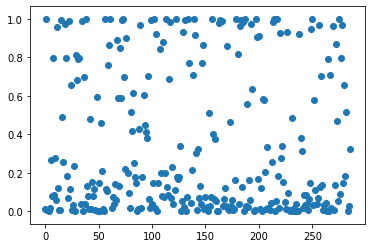

In [230]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

x_tr, x_te, y_tr, y_te = train_test_split(data, target, stratify= target)
clf_accident = LogisticRegression().fit(x_tr, y_tr)
print(clf_accident.score(x_te, y_te))
plt.scatter(range(x_te.shape[0]), clf_accident.predict_proba(x_te)[:,1]);

<IPython.core.display.Javascript object>

C:\Users\Houcine's laptop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8846153846153846


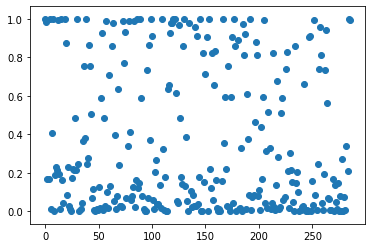

In [231]:
is_conso = [1 for _ in range(consolidation_context_avg_WV.shape[0])]
is_not_conso = [0 for _ in range(accident_context_avg_WV.shape[0])]
data = np.concatenate((consolidation_context_avg_WV, accident_context_avg_WV))
target = np.concatenate((is_conso, is_not_conso))

x_tr, x_te, y_tr, y_te = train_test_split(data, target, stratify= target)
clf_conso = LogisticRegression().fit(x_tr, y_tr)
print(clf_conso.score(x_te, y_te))
plt.scatter(range(x_te.shape[0]), clf_accident.predict_proba(x_te)[:,1]);

In [241]:
text = "société agence voyages fitour, 18 janvier 2002, relève appel incident sollicite mise hors cause, aucune faute imputable."

text_no_date = 'société agence voyages fitour, , relève appel incident sollicite mise hors cause, aucune faute imputable.'

text_no_date_processed = " ".join([tok for tok in text_no_date.split() if tok.isalnum()])

In [244]:
clf_accident.predict_proba([nlp(text_no_date_processed).vector])

array([[0.95305513, 0.04694487]])

In [245]:
clf_conso.predict_proba([nlp(text_no_date_processed).vector])

array([[0.99596141, 0.00403859]])

In [194]:
regex = '(?i)\n(.*(?:( \d{1,2} [a-zéû]{3,9} \d\d\d\d)|(\d{1,2}[^0-9]\d{1,2}[^0-9]\d\d\d\d)).*[.])'

In [196]:
re.match(regex, "  né le 07 Mai 1951")